In [1]:
%pwd

'/home/GPU/GallupWellBeingGroup/Code'

In [2]:
cd ..

/home/GPU/GallupWellBeingGroup


/home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Import Pacakge

In [3]:
from joblib import dump
import os 
import pandas as pd
import xgboost as xgb
import random
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

In [4]:
import shap
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [5]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load and make dataset

In [6]:
parquet_file_path = 'Data/GallupWB_WashdataEnergy_1.967Mvar_v3.parquet'

In [7]:
Df = pd.read_parquet(parquet_file_path, engine='pyarrow')

In [8]:
Df.shape

(1967478, 67)

In [9]:
Df.columns

Index(['Disability', 'Food', 'Shelter', 'Relatives', 'Satisfy_life',
       'Wellrested', 'Treated_respect', 'Smile_Laugh', 'Learn_interesting',
       'Enjoyment', 'Physical_pain', 'Worry', 'Sadness', 'Stress', 'Anger',
       'Satisfied_city', 'Move_city', 'Recommend_city', 'Find_job',
       'Public_transportation', 'Roads_highways', 'Education', 'Air_quality',
       'Water_quality', 'Health_care', 'Good_housing', 'Friends_make',
       'Racial_minority', 'Gay_les', 'Immigrants', 'Donation', 'Voluntary',
       'Help_stranger', 'Voice_opinion', 'Confidence', 'Safety', 'Steal',
       'Assualted', 'Children_respected', 'Children_learn', 'Women_respected',
       'Preserve_environment', 'Freedom_life', 'Military', 'Judicial_system',
       'Government', 'Banks', 'election_honesty', 'Corruption_business',
       'Corruption_government', 'Gender', 'Leadership_country',
       'Marital_status', 'Acess_internet', 'Use_internet', 'Phone_internet',
       'Life_standard', 'Economic_trend',

## Check difference between 

## Shuffle Conversion for Step 1

Economic_trend Model: Isolate indirect effect of features on Wellbeing

One-hot Encoding for Country

In [10]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the LabelEncoder on the categorical column and transform it
Df_encoded = encoder.fit_transform(Df[['COUNTRY_ISO3']])

Df_encoded = pd.DataFrame(Df_encoded, columns=encoder.get_feature_names_out(['COUNTRY_ISO3']))
Df = Df.drop(columns=['COUNTRY_ISO3']).reset_index(drop=True)
Df = pd.concat([Df, Df_encoded], axis=1)

In [11]:
Df.shape

(1967478, 231)

In [12]:
Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
ye1 = Df['Economic_trend']

In [14]:
Xe1 = Df.drop(columns=['Wellbeing_ladder','Economic_trend'])

In [15]:
Xe1_train, Xe1_test, ye1_train, ye1_test = train_test_split(Xe1, ye1, test_size=0.1, random_state=42)

In [16]:
Xe1_train.shape

(1770730, 229)

## Model and Tuning Hyper for Step 1

### Bayes Search CV for Step 1

Bayes for accuracy

In [17]:
param_space = {
    'n_estimators': Integer(100, 5000),
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 16),
    'subsample': Real(0.5, 1.0),
    'min_child_weight': Real(0.001, 10, prior='log-uniform'),
    'max_delta_step': Real(0.001, 10, prior='log-uniform'),
    'reg_lambda': Real(0.001, 10, prior='log-uniform'),
    'reg_alpha': Real(0.001, 10, prior='log-uniform'),
    'gamma': Real(0.001, 10, prior='log-uniform')
}

In [18]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',tree_method='hist', device='cuda', random_state=42, enable_categorical=True  )

In [19]:
class RandomRunNFoldsKFold(KFold):
    def __init__(self, n_splits=10, random_state=None, run_splits=3, **kwargs):
        super().__init__(n_splits=n_splits, shuffle=True, random_state=random_state, **kwargs)
        self.random_state = random_state
        self.actual_splits = run_splits  # Number of actual splits to use

    def split(self, X, y=None, groups=None):
        folds = list(super().split(X, y, groups))
        if self.random_state is not None:
            random.seed(self.random_state)
        selected_folds = random.sample(folds, self.actual_splits)
        for train_index, test_index in selected_folds:
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.actual_splits

In [20]:
rkfcv = RandomRunNFoldsKFold(n_splits=10, run_splits=3, random_state=42)

In [21]:
bayes_research = BayesSearchCV(
    estimator=xgb_classifier,
    search_spaces=param_space,
    n_iter=20,
    scoring='accuracy',
    cv=rkfcv,
    n_jobs = 1,
    n_points = 1,
    verbose=2,
    random_state=42,
    return_train_score = True
)

In [22]:
bayes_research.fit(Xe1, ye1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:24:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 8.0min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 8.0min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 8.0min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gamma=2.2364202820542705, learning_rate=0.05842928269761146, max_delta_

BayesSearchCV(cv=RandomRunNFoldsKFold(n_splits=10, random_state=42, run_splits=None),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device='cuda',
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, imp...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [23]:
bayes_research.best_params_

OrderedDict([('gamma', 0.0011334245815450839),
             ('learning_rate', 0.031243407107141307),
             ('max_delta_step', 1.3079048738216466),
             ('max_depth', 12),
             ('min_child_weight', 0.007663062476312254),
             ('n_estimators', 4887),
             ('reg_alpha', 1.0129760023052234),
             ('reg_lambda', 0.004410721892791114),
             ('subsample', 0.9778806296266178)])

In [24]:
pd.DataFrame(bayes_research.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_delta_step,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,rank_train_score
0,477.028121,0.658882,5.176408,0.057296,0.043693,0.028540,5.388551,7,0.479283,2129,...,0.665125,0.665925,0.000566,7,0.681234,0.680844,0.681151,0.681076,0.000168,10
1,90.072144,0.400082,0.927934,0.016575,2.236420,0.058429,0.016355,15,2.860959,405,...,0.613597,0.615246,0.001613,20,0.616408,0.616395,0.616547,0.616450,0.000068,20
2,473.900123,14.242632,4.573603,0.043465,0.060163,0.068777,0.002627,9,0.005647,2323,...,0.618268,0.619978,0.001516,19,0.621836,0.621461,0.621752,0.621683,0.000161,19
3,260.547838,0.346683,2.374990,0.011398,1.776577,0.002207,0.246711,13,0.123654,568,...,0.642695,0.643690,0.000952,14,0.653223,0.653063,0.653250,0.653179,0.000082,14
4,1244.154793,2.429233,14.141244,0.089677,1.578388,0.007517,0.127785,12,4.124851,3613,...,0.660998,0.661787,0.000591,9,0.682735,0.682897,0.682774,0.682802,0.000069,9
5,393.007390,0.134827,2.677492,0.088344,0.863201,0.075638,0.004513,5,1.592256,1926,...,0.629907,0.631002,0.001318,17,0.632333,0.632417,0.632564,0.632438,0.000095,17
6,1115.991822,3.478886,13.324044,0.070636,0.293980,0.035541,0.027296,14,0.234681,3014,...,0.663031,0.663822,0.000580,8,0.688893,0.689491,0.689089,0.689158,0.000249,8
7,221.320341,0.353087,2.218631,0.036844,0.149146,0.069186,0.096798,14,0.019781,351,...,0.660688,0.661467,0.000598,11,0.703827,0.703722,0.704314,0.703954,0.000258,6
8,232.502922,0.304474,2.054187,0.056074,6.636085,0.025191,3.066251,8,0.033439,1136,...,0.654822,0.656074,0.000917,12,0.659915,0.659931,0.660207,0.660018,0.000134,12
9,297.191434,0.381618,3.199556,0.080414,0.001034,0.043218,0.922850,6,0.206375,1446,...,0.660022,0.661476,0.001049,10,0.669077,0.668955,0.669178,0.669070,0.000091,11


In [61]:
dump(bayes_research, "Results/Shi_BayesPhrase1SearchingResults.joblib")

['Results/Shi_BayesPhrase1SearchingResults.joblib']

In [ ]:
bayes_search = BayesSearchCV(
    estimator=xgb_classifier,
    search_spaces=param_space,
    n_iter=20,
    scoring='r2',
    cv=rkfcv,
    n_jobs = 1,
    n_points = 1,
    verbose=2,
    random_state=42,
    return_train_score = True
)

In [ ]:
bayes_search.fit(Xe1, ye1)

In [ ]:
bayes_search.best_params_

### XgbClassifier for Step1: Figure out effects of features on Ecnomic_trend

In [25]:
model = xgb.XGBClassifier(objective='multi:softprob',num_class=3, n_jobs=-1, device='cuda',
                         tree_method='hist', random_state=42, enable_categorical=True, **bayes_research.best_params_)
model.fit(Xe1_train, ye1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.0011334245815450839, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.031243407107141307, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=1.3079048738216466, max_depth=12, max_leaves=None,
              min_child_weight=0.007663062476312254, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4887,
              n_jobs=-1, num_class=3, num_parallel_tree=None, ...)

In [66]:
ye1_pred_prob = model.predict_proba(Xe1_test)

In [67]:
ye1_pred_prob.shape

(196748, 3)

In [68]:
ye1_pred_prob[:5]

array([[0.25520572, 0.4815416 , 0.26325262],
       [0.03859945, 0.9387692 , 0.02263133],
       [0.02194302, 0.74229246, 0.23576449],
       [0.02172999, 0.7550013 , 0.2232687 ],
       [0.46621147, 0.04694035, 0.48684815]], dtype=float32)

In [69]:
ye1_pred = model.predict(Xe1_test)

In [70]:
accuracy = accuracy_score(ye1_test, ye1_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6754325329863582


In [30]:
confusion_matrix(ye1_test, ye1_pred)

array([[40504, 11418,  8706],
       [10077, 52679,  7980],
       [11969, 13708, 39707]])

In [72]:
ye1_train_pred_prob = model.predict_proba(Xe1_train)

In [73]:
ye1_test_pred_prob = model.predict_proba(Xe1_test)

In [77]:
Df_2phrase = Df.copy()

In [78]:
Df_2phrase.loc[Xe1_train.index, ['Predicted_Economic_trend_0', 'Predicted_Economic_trend_1', 'Predicted_Economic_trend_2']] = ye1_train_pred_prob
Df_2phrase.loc[Xe1_test.index, ['Predicted_Economic_trend_0', 'Predicted_Economic_trend_1', 'Predicted_Economic_trend_2']] = ye1_test_pred_prob

In [79]:
Df_2phrase.head()

,Disability,Food,Shelter,Relatives,Satisfy_life,Wellrested,Treated_respect,Smile_Laugh,Learn_interesting,Enjoyment,...,COUNTRY_ISO3_XNC,COUNTRY_ISO3_XNK,COUNTRY_ISO3_XSR,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE,Predicted_Economic_trend_0,Predicted_Economic_trend_1,Predicted_Economic_trend_2
0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058186,0.870641,0.071173
1,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000606,0.000516,0.998879
2,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098720,0.650864,0.250416
3,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.803382,0.067895,0.128723
4,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071684,0.739415,0.188901


In [85]:
Df_2phrase.to_parquet('Data/GallupWB_WashedDataEnergy1x967mPhrase2_v1.parquet')

In [89]:
del model

#### Check xgbClassifier model

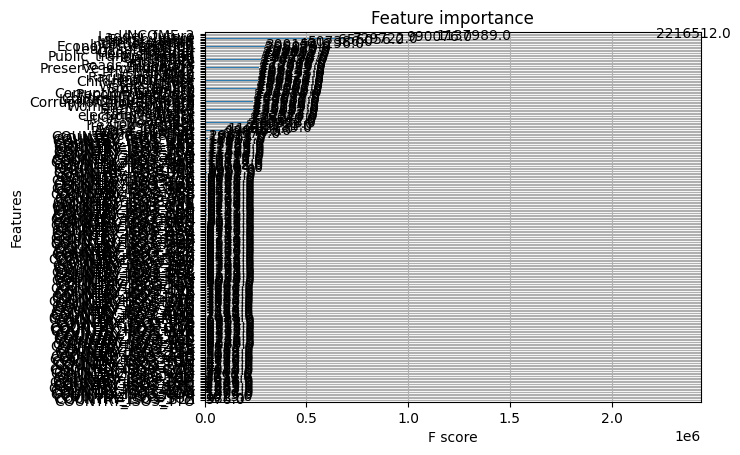

In [36]:
plot_importance(model)
plt.show()

## Shuffle Conversion for Step 2

### Bayes Research for step 2

In [6]:
Df_2phrase =  pd.read_parquet('Data/GallupWB_WashedDataEnergy1x967mPhrase2_v1.parquet')

In [7]:
ye2 = Df_2phrase['Wellbeing_ladder']

In [8]:
Xe2 = Df_2phrase.drop(columns=['Wellbeing_ladder'])

In [9]:
Xe2.head()

,Disability,Food,Shelter,Relatives,Satisfy_life,Wellrested,Treated_respect,Smile_Laugh,Learn_interesting,Enjoyment,...,COUNTRY_ISO3_XNC,COUNTRY_ISO3_XNK,COUNTRY_ISO3_XSR,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE,Predicted_Economic_trend_0,Predicted_Economic_trend_1,Predicted_Economic_trend_2
0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058186,0.870641,0.071173
1,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000606,0.000516,0.998879
2,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098720,0.650864,0.250416
3,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.803382,0.067895,0.128723
4,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071684,0.739415,0.188901


In [10]:
Xe2_train, Xe2_test, ye2_train, ye2_test = train_test_split(Xe2, ye2, test_size=0.1, random_state=42)

In [11]:
Xe2_train.head()

,Disability,Food,Shelter,Relatives,Satisfy_life,Wellrested,Treated_respect,Smile_Laugh,Learn_interesting,Enjoyment,...,COUNTRY_ISO3_XNC,COUNTRY_ISO3_XNK,COUNTRY_ISO3_XSR,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE,Predicted_Economic_trend_0,Predicted_Economic_trend_1,Predicted_Economic_trend_2
324711,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037243,0.815078,0.147678
1230975,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513526,0.466467,0.020007
1121432,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087200,0.869279,0.043521
530164,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797858,0.086301,0.115842
156378,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000970,0.000596,0.998433


In [12]:
param_space = {
    'n_estimators': Integer(100, 5000),
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 16),
    'subsample': Real(0.5, 1.0),
    'min_child_weight': Real(0.001, 10, prior='log-uniform'),
    'max_delta_step': Real(0.001, 10, prior='log-uniform'),
    'reg_lambda': Real(0.001, 10, prior='log-uniform'),
    'reg_alpha': Real(0.001, 10, prior='log-uniform'),
    'gamma': Real(0.001, 10, prior='log-uniform')
}

In [15]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',tree_method='hist', device='cuda', random_state=42)

In [16]:
class RandomRunNFoldsKFold(KFold):
    def __init__(self, n_splits=10, random_state=None, run_splits=3, **kwargs):
        super().__init__(n_splits=n_splits, shuffle=True, random_state=random_state, **kwargs)
        self.random_state = random_state
        self.actual_splits = run_splits  # Number of actual splits to use

    def split(self, X, y=None, groups=None):
        folds = list(super().split(X, y, groups))
        if self.random_state is not None:
            random.seed(self.random_state)
        selected_folds = random.sample(folds, self.actual_splits)
        for train_index, test_index in selected_folds:
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.actual_splits

In [17]:
rkfcv = RandomRunNFoldsKFold(n_splits=10, run_splits=3, random_state=42)

In [18]:
bayes_research2 = BayesSearchCV(
    estimator=xgb_reg,
    search_spaces=param_space,
    n_iter=20,
    scoring='r2',
    cv=rkfcv,
    n_jobs = 1,
    n_points = 1,
    verbose=2,
    random_state=42,
    return_train_score = True
)

In [19]:
bayes_research2.fit(Xe2, ye2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:58:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=25.0min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=25.0min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=25.0min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gamma=2.2364202820542705, learning_rate=0.05842928269761146, max_delta_

BayesSearchCV(cv=RandomRunNFoldsKFold(n_splits=10, random_state=42, run_splits=None),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device='cuda',
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, imp...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [20]:
bayes_research2.best_params_

OrderedDict([('gamma', 0.023673051277355004),
             ('learning_rate', 0.06902171596245149),
             ('max_delta_step', 0.22257808428181192),
             ('max_depth', 15),
             ('min_child_weight', 0.015518184973237342),
             ('n_estimators', 1383),
             ('reg_alpha', 2.9043022731395447),
             ('reg_lambda', 0.0014820688110528642),
             ('subsample', 0.7821136409869307)])

In [21]:
dump(bayes_research2, "Results/Shi_BayesPhrase2SearchingResults.joblib")

['Results/Shi_BayesPhrase2SearchingResults.joblib']

In [24]:
model2 = xgb.XGBRegressor(objective='reg:squarederror',device='cuda',
                         tree_method='hist', random_state=42, **bayes_research2.best_params_)
model2.fit(Xe2_train, ye2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.023673051277355004, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06902171596245149,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0.22257808428181192, max_depth=15, max_leaves=None,
             min_child_weight=0.015518184973237342, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1383,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [25]:
ye2_pred = model2.predict(Xe2_test)

In [26]:
ye2_pred.shape

(196748,)

In [31]:
r2 = r2_score(ye2_test, ye2_pred)
print(f"r2_score: {r2}")

r2_score: 0.5287616462640119


In [ ]:
ye2_train_pred = model.predict(Xe2_train)

In [ ]:
ye2_test_pred = model.predict(Xe2_test)

SHAP values

In [57]:
explainer = shap.TreeExplainer(model2)

In [58]:
shap_values = explainer.shap_values(Xe2_train)

XGBoostError: [01:37:39] /workspace/src/c_api/../common/device_helpers.cuh:400: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 15363866624
- Requested memory: 18075611840

Stack trace:
  [bt] (0) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x22d7cc) [0x7f6e6e20b7cc]
  [bt] (1) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x8961a6) [0x7f6e6e8741a6]
  [bt] (2) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x8e782a) [0x7f6e6e8c582a]
  [bt] (3) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x91664e) [0x7f6e6e8f464e]
  [bt] (4) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0xca1c1b) [0x7f6e6ec7fc1b]
  [bt] (5) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x58f906) [0x7f6e6e56d906]
  [bt] (6) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x2a8) [0x7f6e6e1196f8]
  [bt] (7) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/lib-dynload/../../libffi.so.8(+0xa052) [0x7f6f056a3052]
  [bt] (8) /home/GPU/miniconda3/envs/MLlearning/lib/python3.9/lib-dynload/../../libffi.so.8(+0x8925) [0x7f6f056a1925]



In [ ]:
print(f"SHAP values shape: {shap_values.shape}")

In [49]:
print(f'SHAP values shape: {shap_values[1].shape}')  # For class 1

SHAP values shape: (65, 3)


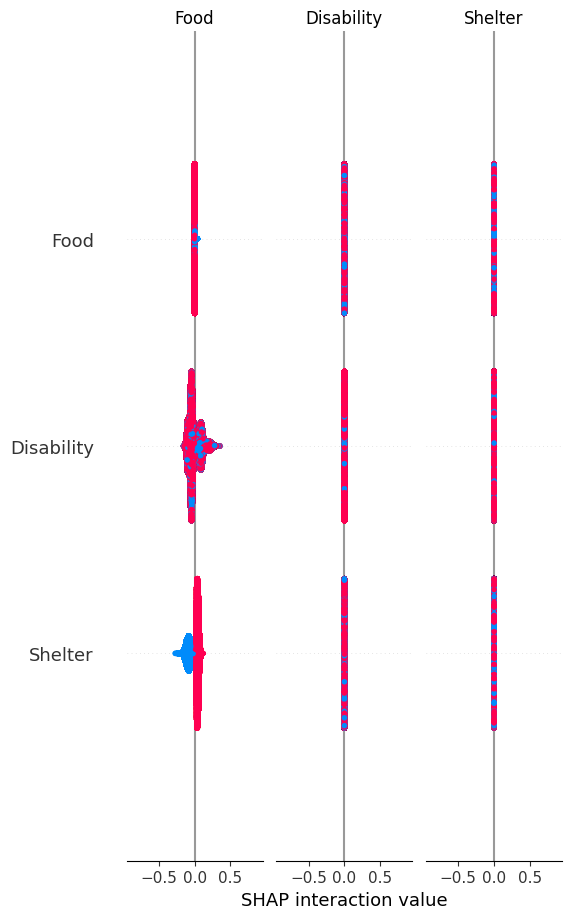

In [53]:
shap.summary_plot(shap_values, Xe2_train, feature_names=feature_names, plot_type="bar", max_display=10)

In [33]:
n_estimators_list = list(range(100, 300, 50))
learning_rate_list = [0.05, 0.1]
max_depth_list = [5,10,15]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]

In [34]:
results_list = []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            for subsample in subsample_list:
                model = xgb.XGBClassfier(objective='binary:logistic', 
                                         n_estimators = n_estimators,
                                         learning_rate = learning_rate, 
                                         max_depth = max_depth, 
                                         subsample = subsample,
                                         random_state=42, enable_categorical=True  )
                model.fit(Xe_train, ye_train)
                ye_pred = model.predict(Xe_test)
                test_r2 = r2_score(ye_test, ye_pred) * 100
                ye_train_pred = model.predict(Xe_train)
                train_r2 = r2_score(ye_train, ye_train_pred) * 100
                row = [n_estimators, learning_rate, max_depth, 
                       subsample, train_r2, test_r2]
                print(row)
                model = None
                ye_pred = None
                ye_train_pred = None
                results_list.append(row)

[50, 0.05, 5, 0.6, 99.4079357100152, 99.40792611208336]
[50, 0.05, 5, 0.7, 99.40793749453941, 99.40792790509471]
[50, 0.05, 5, 0.8, 99.40793927905838, 99.40792969810079]
[50, 0.05, 5, 0.9, 99.40793927905838, 99.40792969810079]
[50, 0.05, 5, 1, 99.40794022132275, 99.40793063565667]
[50, 0.05, 10, 0.6, 99.4079357100152, 99.40792611208336]
[50, 0.05, 10, 0.7, 99.40793749453941, 99.40792790509471]
[50, 0.05, 10, 0.8, 99.40793927905838, 99.40792969810079]
[50, 0.05, 10, 0.9, 99.40793927905838, 99.40792969810079]
[50, 0.05, 10, 1, 99.40794022132275, 99.40793063565667]
[50, 0.05, 15, 0.6, 99.4079357100152, 99.40792611208336]
[50, 0.05, 15, 0.7, 99.40793749453941, 99.40792790509471]
[50, 0.05, 15, 0.8, 99.40793927905838, 99.40792969810079]
[50, 0.05, 15, 0.9, 99.40793927905838, 99.40792969810079]
[50, 0.05, 15, 1, 99.40794022132275, 99.40793063565667]
[50, 0.1, 5, 0.6, 99.99734373387524, 99.99734369148592]
[50, 0.1, 5, 0.7, 99.99734373387524, 99.99734369148592]
[50, 0.1, 5, 0.8, 99.99734373387

### PSM for Step 1

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [26]:
Df.shape

(1967478, 67)

In [30]:
X = Df[['Food', 'Disability','Shelter']]
T = Df['Economic_trend']
le = LabelEncoder()


# Calculate propensity scores
model_PSM = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_PSM.fit(X, T)
propensity_scores = model_PSM.predict_proba(X)

for idx, Economic_trend in enumerate(model_PSM.classes_):
    Df[f'propensity_score_{Economic_trend}'] = propensity_scores[:,idx]


/opt/anaconda3/envs/MLlearning/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [32]:
for idx, level in enumerate(model_PSM.classes_):
    Df[f'propensity_score_{level}'] = propensity_scores[:, idx]

# Step 3: Perform Matching for each treatment level
def match_on_propensity_score(Df, level):
    treated = Df[Df['Economic_trend'] == level]
    control = Df[Df['Economic_trend'] != level]
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[[f'propensity_score_{level}']])
    distances, indices = nn.kneighbors(treated[[f'propensity_score_{level}']])
    matched_control = control.iloc[indices.flatten()]
    return treated, matched_control

matched_data = pd.DataFrame()
for level in model_PSM.classes_:
    treated, matched_control = match_on_propensity_score(Df, level)
    matched_data = pd.concat([matched_data, treated, matched_control])

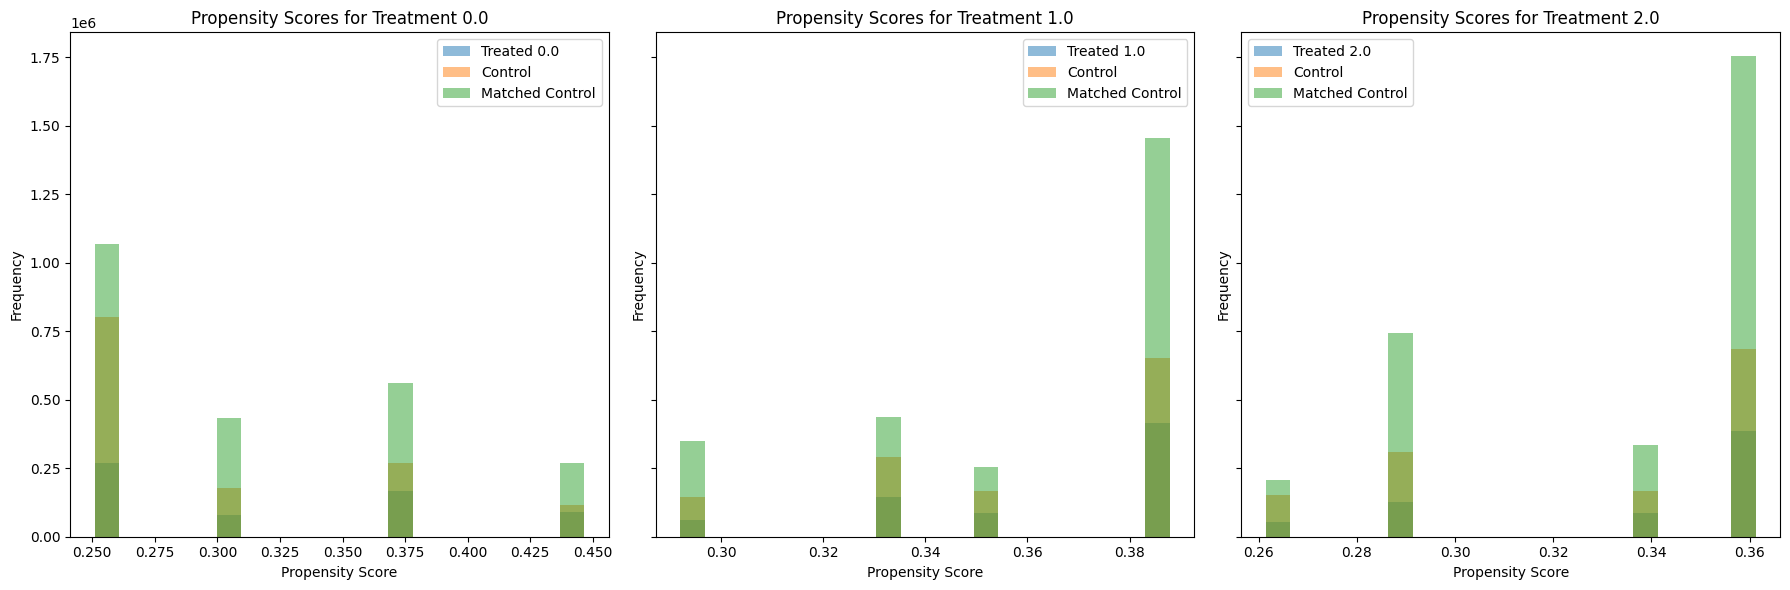

In [33]:
# Step 4: Visualize Propensity Score Distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for idx, level in enumerate(model_PSM.classes_):
    treated = Df[Df['Economic_trend'] == level]
    control = Df[Df['Economic_trend'] != level]
    matched_control = matched_data[matched_data['Economic_trend'] != level]
    
    axs[idx].hist(treated[f'propensity_score_{level}'], bins=20, alpha=0.5, label=f'Treated {level}')
    axs[idx].hist(control[f'propensity_score_{level}'], bins=20, alpha=0.5, label='Control')
    axs[idx].hist(matched_control[f'propensity_score_{level}'], bins=20, alpha=0.5, label='Matched Control')
    axs[idx].set_title(f'Propensity Scores for Treatment {level}')
    axs[idx].set_xlabel('Propensity Score')
    axs[idx].set_ylabel('Frequency')
    axs[idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install gams